In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import ADASYN
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('03_Cleaned_File(Data Preprocessing).csv')

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Gender,Age,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42,101348.88,0.00,1,1,2,1,1,0,0
1,15647311,Hill,608,0,41,112542.58,83807.86,1,1,1,1,0,0,1
2,15619304,Onio,502,0,42,113931.57,159660.80,3,0,8,0,1,0,0
3,15701354,Boni,699,0,39,93826.63,0.00,2,0,1,0,0,0,0
4,15737888,Mitchell,850,0,43,79084.10,125510.82,1,1,2,1,0,0,1


In [4]:
X = df.drop(columns = ['CustomerId', 'Surname', 'Exited'])
y = df['Exited']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

In [6]:
num_features = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
preprocessor = ColumnTransformer(transformers = [('num', StandardScaler(), num_features)],
                                 remainder = 'passthrough',
                                 force_int_remainder_cols=False)

In [7]:
steps = [("preprocess", preprocessor),
         ("adasyn", ADASYN(random_state = 42)),
         ("gradient_boost", GradientBoostingClassifier(random_state = 42))]

In [8]:
pipe = Pipeline(steps)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('gradient_boost',
                 GradientBoostingClassifier(random_state=42))])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'EstimatedSalary',
                                                   'Balance'])])),
                ('adasyn', ADASYN(random_state=42)),
                ('gradient_boost',
                 GradientBoostingClassifier(random_state=42))])

In [10]:
y_pred = pipe.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
param_grid = {
    'gradient_boost__n_estimators': [50, 100, 200, 300],
    'gradient_boost__learning_rate': [0.001, 0.01, 0.1, 1.0],
    "gradient_boost__max_depth": [1, 2, 3],
    "gradient_boost__subsample": [0.8, 1.0]
}

In [12]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
grid_search = GridSearchCV(estimator = pipe,
                           param_grid = param_grid,
                           scoring = scoring,
                           refit = 'recall',           
                           cv = 5,
)

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'EstimatedSalary',
                                                                          'Balance'])])),
                                       ('adasyn', ADASYN(random_state=42)),
                                       ('gradient_boost',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'gradient_boost__learning_rate': [0.001, 0.01, 0.1,
                                                           1.0],
                         'gradient_boost__max_depth': [1, 2, 3],
                         'gradient_boost__n_estimators': [50, 100, 200, 300],
                         'gradient_boost__subsample': [0.8, 1.0]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [14]:
grid_search.best_params_

{'gradient_boost__learning_rate': 0.001,
 'gradient_boost__max_depth': 1,
 'gradient_boost__n_estimators': 50,
 'gradient_boost__subsample': 0.8}

In [15]:
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

In [16]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[   0, 2389],
       [   0,  611]], dtype=int64)

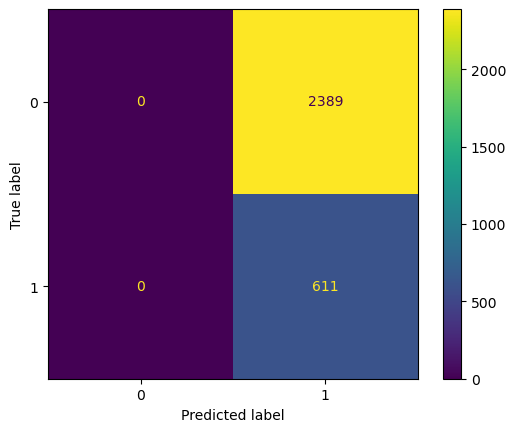

In [17]:
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [18]:
class0_accuracy = cm[0,0] / cm[0].sum()
class1_accuracy = cm[1,1] / cm[1].sum()
print(f"Class 0 Accuracy: {class0_accuracy:.2f}")
print(f"Class 1 Accuracy: {class1_accuracy:.2f}")

Class 0 Accuracy: 0.00
Class 1 Accuracy: 1.00


In [19]:
print(f'Accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision : {precision_score(y_test, y_pred):.2f}')
print(f'Recall : {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score : {f1_score(y_test, y_pred):.2f}')

Accuracy : 0.20
Precision : 0.20
Recall : 1.00
F1 Score : 0.34


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2389
           1       0.20      1.00      0.34       611

    accuracy                           0.20      3000
   macro avg       0.10      0.50      0.17      3000
weighted avg       0.04      0.20      0.07      3000



c:\Users\amand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\amand\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
y_prob = best_dt.predict_proba(X_test)[:, 1]
y_prob

array([0.50388492, 0.50388492, 0.50388492, ..., 0.50388492, 0.50388492,
       0.50388492])

In [24]:
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
print(f"ROC-AUC Score:{roc_auc:.2f}")
print(f"PR-AUC Score:{pr_auc:.2f}")

ROC-AUC Score:0.71
PR-AUC Score:0.34


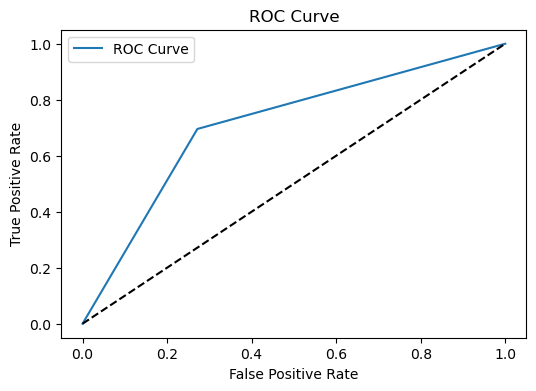

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

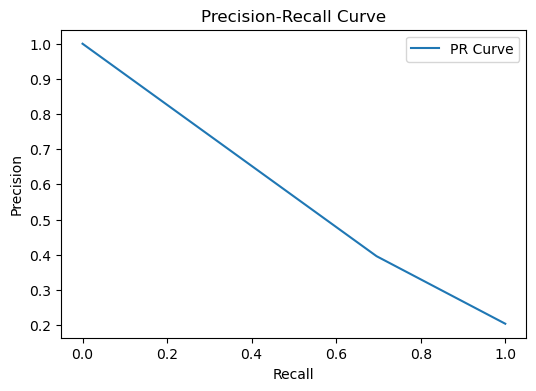

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()